In [37]:
#CATBOOST - trening i wizualizacja, jak model działa

In [38]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler

def random_undersample(X, y, random_state=42):
    rus = RandomUnderSampler(random_state=random_state)
    X_res, y_res = rus.fit_resample(X, y)
    return X_res, y_res

def random_oversample(X, y, random_state=42):
    ros = RandomOverSampler(random_state=random_state)
    X_res, y_res = ros.fit_resample(X, y)
    return X_res, y_res

def apply_smote(X, y, random_state=42, k_neighbors=5):
    smote = SMOTE(random_state=random_state, k_neighbors=k_neighbors)
    X_res, y_res = smote.fit_resample(X, y)
    return X_res, y_res

def apply_adasyn(X, y, random_state=42, n_neighbors=5):
    adasyn = ADASYN(random_state=random_state, n_neighbors=n_neighbors)
    X_res, y_res = adasyn.fit_resample(X, y)
    return X_res, y_res

In [39]:
import optuna
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, precision_score
from sklearn.model_selection import cross_val_score
import joblib
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df = pd.read_csv('70_percent_ls.csv')
df.head()

# Zakładamy, że kolumna celu nazywa się:
target_column = 'Lung_Cancer_Diagnosis'

X = df.drop(columns=[target_column])
y = df[target_column]

from sklearn.model_selection import train_test_split

X_train_temp, X_test, y_train_temp, y_test = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,        # zachowujemy proporcje klas!
    random_state=42
)



X_train, y_train = apply_adasyn(X_train_temp,y_train_temp)



def objective(trial):
    params = {
    "iterations": 500,
    "early_stopping_rounds": 50,
    "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
    "scale_pos_weight": 1.0,  # usuwamy wpływ
    "depth": trial.suggest_int("depth", 4, 6),
    "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 10.0),
    "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
    "random_strength": trial.suggest_float("random_strength", 0.0, 10.0),
    "border_count": trial.suggest_int("border_count", 32, 255),
    "loss_function": 'Logloss',
    #"eval_metric": 'f1',  # lub 'Recall', lub 'AUC'
    "verbose": 0,
    "random_state": 42,
}

    model = CatBoostClassifier(**params)
    
    # używamy average_precision, bo lepiej działa na niezbalansowanych danych
    score = cross_val_score(model, X_train, y_train, cv=3, scoring="average_precision").mean()
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=15)#bo na razie nie mam czasu, a zaraz chce [przetestowac] co jak mi poszło

print("Best parameters:", study.best_params)


[I 2025-04-22 22:31:09,113] A new study created in memory with name: no-name-fdd610cd-74e2-44c9-b19f-23cc83bf0e74
[I 2025-04-22 22:31:39,300] Trial 0 finished with value: 0.9756217930500931 and parameters: {'learning_rate': 0.06756001204992025, 'depth': 6, 'l2_leaf_reg': 3.6697303525885783, 'bagging_temperature': 0.4447990634146155, 'random_strength': 1.370801685509675, 'border_count': 194}. Best is trial 0 with value: 0.9756217930500931.
[I 2025-04-22 22:32:10,021] Trial 1 finished with value: 0.9695757159489847 and parameters: {'learning_rate': 0.068369323266294, 'depth': 6, 'l2_leaf_reg': 7.114226831337325, 'bagging_temperature': 0.7049014641314838, 'random_strength': 8.340964766740303, 'border_count': 144}. Best is trial 0 with value: 0.9756217930500931.
[I 2025-04-22 22:32:38,948] Trial 2 finished with value: 0.9289917049292874 and parameters: {'learning_rate': 0.010590803712480078, 'depth': 6, 'l2_leaf_reg': 1.9778545954331803, 'bagging_temperature': 0.5912412480150795, 'random_s

Best parameters: {'learning_rate': 0.0991285178805118, 'depth': 6, 'l2_leaf_reg': 9.841321241799447, 'bagging_temperature': 0.46083323891353645, 'random_strength': 0.2631749279220551, 'border_count': 252}


0:	learn: 0.6098614	total: 28.7ms	remaining: 28.7s
1:	learn: 0.5602658	total: 53ms	remaining: 26.4s
2:	learn: 0.5217627	total: 77.4ms	remaining: 25.7s
3:	learn: 0.5095225	total: 99.7ms	remaining: 24.8s
4:	learn: 0.4845174	total: 126ms	remaining: 25.2s
5:	learn: 0.4707053	total: 150ms	remaining: 24.8s
6:	learn: 0.4558607	total: 172ms	remaining: 24.4s
7:	learn: 0.4446729	total: 195ms	remaining: 24.2s
8:	learn: 0.4398647	total: 221ms	remaining: 24.3s
9:	learn: 0.4262546	total: 244ms	remaining: 24.1s
10:	learn: 0.4180991	total: 269ms	remaining: 24.2s
11:	learn: 0.4077387	total: 296ms	remaining: 24.4s
12:	learn: 0.4039685	total: 321ms	remaining: 24.4s
13:	learn: 0.3932696	total: 345ms	remaining: 24.3s
14:	learn: 0.3881819	total: 370ms	remaining: 24.3s
15:	learn: 0.3854000	total: 396ms	remaining: 24.3s
16:	learn: 0.3801549	total: 423ms	remaining: 24.5s
17:	learn: 0.3744469	total: 446ms	remaining: 24.3s
18:	learn: 0.3713085	total: 471ms	remaining: 24.3s
19:	learn: 0.3696916	total: 494ms	remai

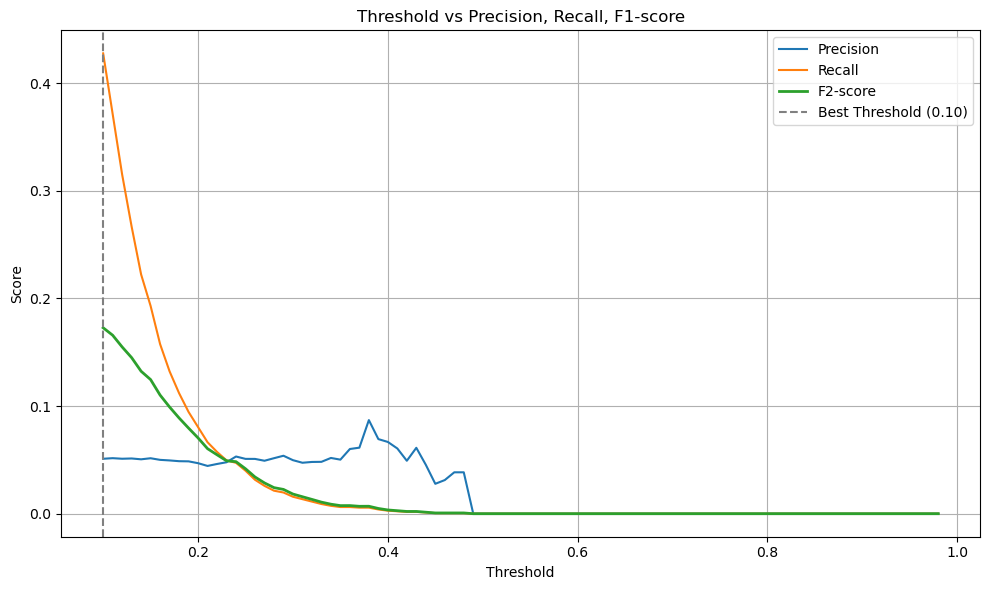

✅ Best threshold: 0.10 


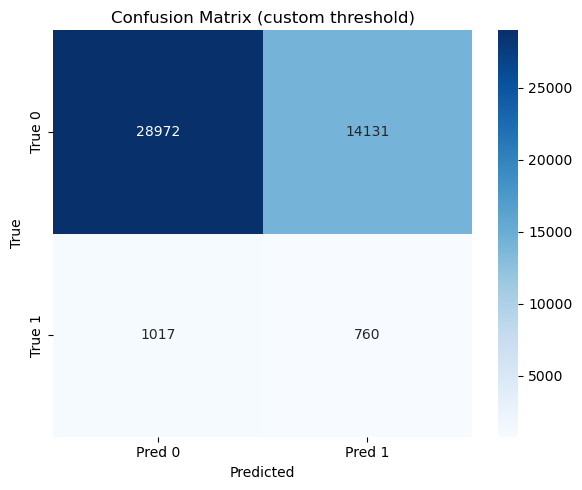

📊 Classification Report (custom threshold):
              precision    recall  f1-score   support

           0       0.97      0.67      0.79     43103
           1       0.05      0.43      0.09      1777

    accuracy                           0.66     44880
   macro avg       0.51      0.55      0.44     44880
weighted avg       0.93      0.66      0.76     44880

F1 Score: 0.09119270458363331
Precision (positive class): 0.05103753945336109


In [40]:
best_params = study.best_params
model = CatBoostClassifier(
    
    **best_params
)
model.fit(X_train, y_train)

# Predykcje prawdopodobieństw i dobór progu
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Przewidujemy prawdopodobieństwa
y_probs = model.predict_proba(X_test)[:, 1]

# Przygotowanie do optymalizacji progu
thresholds = np.arange(0.1, 0.99, 0.01)
results = []
from sklearn.metrics import fbeta_score

for thresh in thresholds:
    y_pred_thresh = (y_probs >= thresh).astype(int)
    precision = precision_score(y_test, y_pred_thresh, zero_division=0)
    recall = recall_score(y_test, y_pred_thresh, zero_division=0)
    f2 = fbeta_score(y_test, y_pred_thresh, beta=2, zero_division=0)
    results.append({'threshold': thresh, 'precision': precision, 'recall': recall, 'f2': f2})

# Konwertujemy wyniki do DataFrame
results_df = pd.DataFrame(results)

# Szukamy najlepszego progu
best_row = results_df.loc[results_df['f2'].idxmax()]
best_thresh = best_row['threshold']

#ponieważ działa to giga kiepsko
#best_thresh = 0.5

print(f"\n🔍 Najlepszy threshold (na podstawie F2-score): {best_thresh:.2f}")
print(best_row)

# Rysujemy wykres
plt.figure(figsize=(10, 6))
plt.plot(results_df['threshold'], results_df['precision'], label='Precision')
plt.plot(results_df['threshold'], results_df['recall'], label='Recall')
plt.plot(results_df['threshold'], results_df['f2'], label='F2-score', linewidth=2)
plt.axvline(best_thresh, color='gray', linestyle='--', label=f'Best Threshold ({best_thresh:.2f})')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Threshold vs Precision, Recall, F1-score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


print(f"✅ Best threshold: {best_thresh:.2f} ")

# Ostateczna predykcja z najlepszym thresholdem
y_pred_final = (y_probs >= best_thresh).astype(int)
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, y_pred_final)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Pred 0", "Pred 1"], yticklabels=["True 0", "True 1"])
plt.title("Confusion Matrix (custom threshold)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# Classification report
print("📊 Classification Report (custom threshold):")
print(classification_report(y_test, y_pred_final, digits=2))

print("F1 Score:", f1_score(y_test, y_pred_final))
print("Precision (positive class):", precision_score(y_test, y_pred_final))


In [41]:
import pickle
def save_model(model, path):
    with open(path, 'wb') as f:
        pickle.dump(model, f)

save_model(model, "models/catboost+adasyn.pkl")


In [42]:
optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_param_importances(study).show()

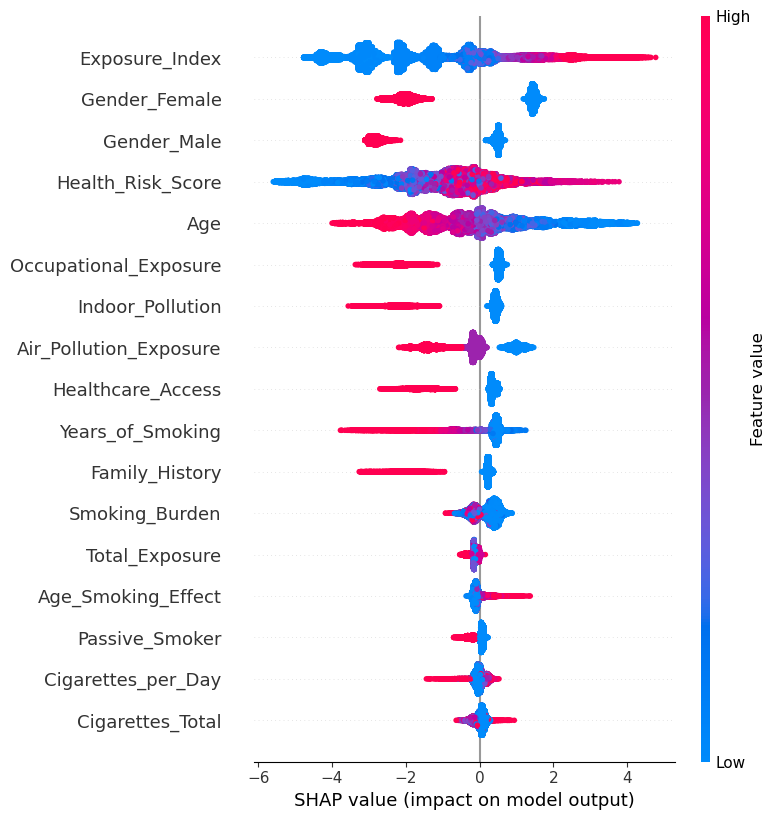

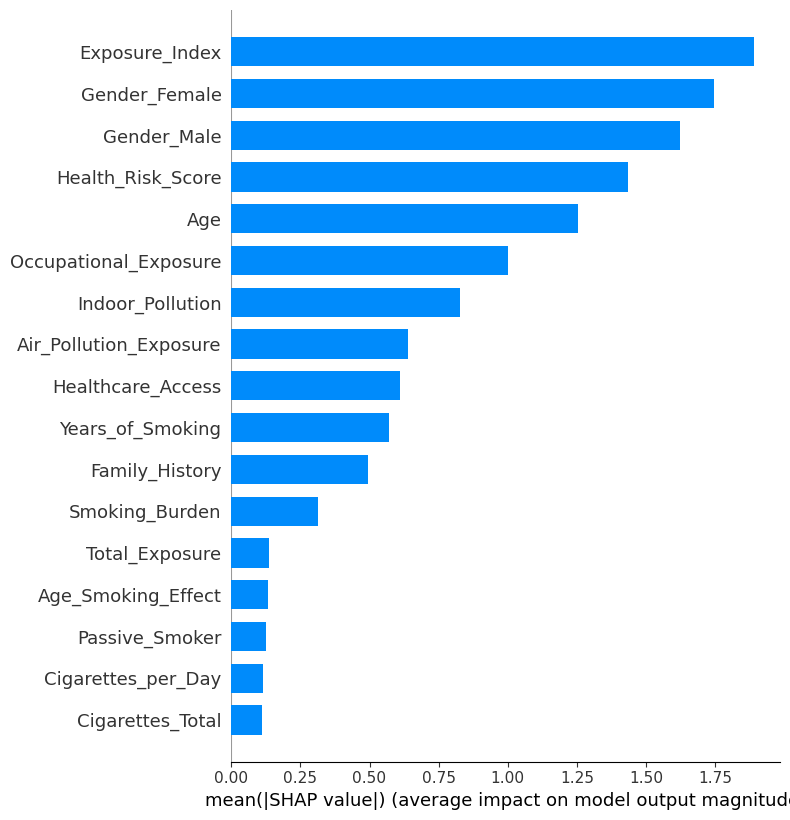

c:\Users\66891\anaconda3\Lib\site-packages\catboost\core.py:945: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



CatBoostError: catboost/libs/data/model_dataset_compatibility.cpp:72: Feature Years_of_Smoking is present in model but not in pool.

In [43]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Wykres ogólny
shap.summary_plot(shap_values, X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")
# Wykres dla pojedynczej próbki
shap.plots.waterfall(explainer(X_test.iloc[20]))  # <-- odkomentuj dla konkretnej obserwacji

